In [1]:
# This notebook demonstrates the lag llama model 
# You do need to manually upload the dataset and have it at the same directory level as this notebook
# The notebook assumes the model is located at /workspace/lag-llama.ckpt

In [1]:
!pwd

/workspace/ll_github


In [2]:
#!cp -R /workspace/tempdir_g/gluon_utils/ .
#!cp -R /workspace/tempdir_g/lag_llama/ .
#cp -R /workspace/tempdir_g/data/ .

In [3]:
from itertools import islice

from matplotlib import pyplot as plt
import matplotlib.dates as mdates

import torch
from gluonts.evaluation import make_evaluation_predictions, Evaluator
from gluonts.dataset.repository.datasets import get_dataset

from gluonts.dataset.pandas import PandasDataset
import pandas as pd

from lag_llama.gluon.estimator import LagLlamaEstimator

In [16]:
def get_lag_llama_predictions(dataset, prediction_length, num_samples=100):
    ckpt = torch.load("/workspace/lag-llama.ckpt", map_location=torch.device('cuda:0')) # Uses GPU since in this Colab we use a GPU.
    estimator_args = ckpt["hyper_parameters"]["model_kwargs"]

    estimator = LagLlamaEstimator(
        ckpt_path="/workspace/lag-llama.ckpt",
        prediction_length=prediction_length,
        context_length=32, # Should not be changed; this is what the released Lag-Llama model was trained with

        # estimator args
        input_size=estimator_args["input_size"],
        n_layer=estimator_args["n_layer"],
        n_embd_per_head=estimator_args["n_embd_per_head"],
        n_head=estimator_args["n_head"],
        scaling=estimator_args["scaling"],
        time_feat=estimator_args["time_feat"],

        batch_size=1,
        num_parallel_samples=100
    )

    lightning_module = estimator.create_lightning_module()
    transformation = estimator.create_transformation()
    predictor = estimator.create_predictor(transformation, lightning_module)

    forecast_it, ts_it = make_evaluation_predictions(
        dataset=dataset,
        predictor=predictor,
        num_samples=num_samples
    )
    forecasts = list(forecast_it)
    tss = list(ts_it)

    return forecasts, tss

In [6]:
## Get Data
# A copy is in the github repo - you have to manually upload it inside jupyter

In [7]:
import pandas as pd
from gluonts.dataset.pandas import PandasDataset

df = pd.read_csv('timedata.csv', index_col=0, parse_dates=True)
df.head()

,target,item_id
timestamp,,
2021-01-01 00:00:00,-1.3378,A
2021-01-01 01:00:00,-1.6111,A
2021-01-01 02:00:00,-1.9259,A
2021-01-01 03:00:00,-1.9184,A
2021-01-01 04:00:00,-1.9168,A


In [17]:
# Set numerical columns as float32
for col in df.columns:
    # Check if column is not of string type
    if df[col].dtype != 'object' and pd.api.types.is_string_dtype(df[col]) == False:
        df[col] = df[col].astype('float32')

# Create the Pandas
dataset = PandasDataset.from_long_dataframe(df, target="target", item_id="item_id")

backtest_dataset = dataset
prediction_length = 24  # Define your prediction length. We use 24 here since the data is of hourly frequency
num_samples = 100 # number of samples sampled from the probability distribution for each timestep

In [18]:
forecasts, tss = get_lag_llama_predictions(backtest_dataset, prediction_length, num_samples)

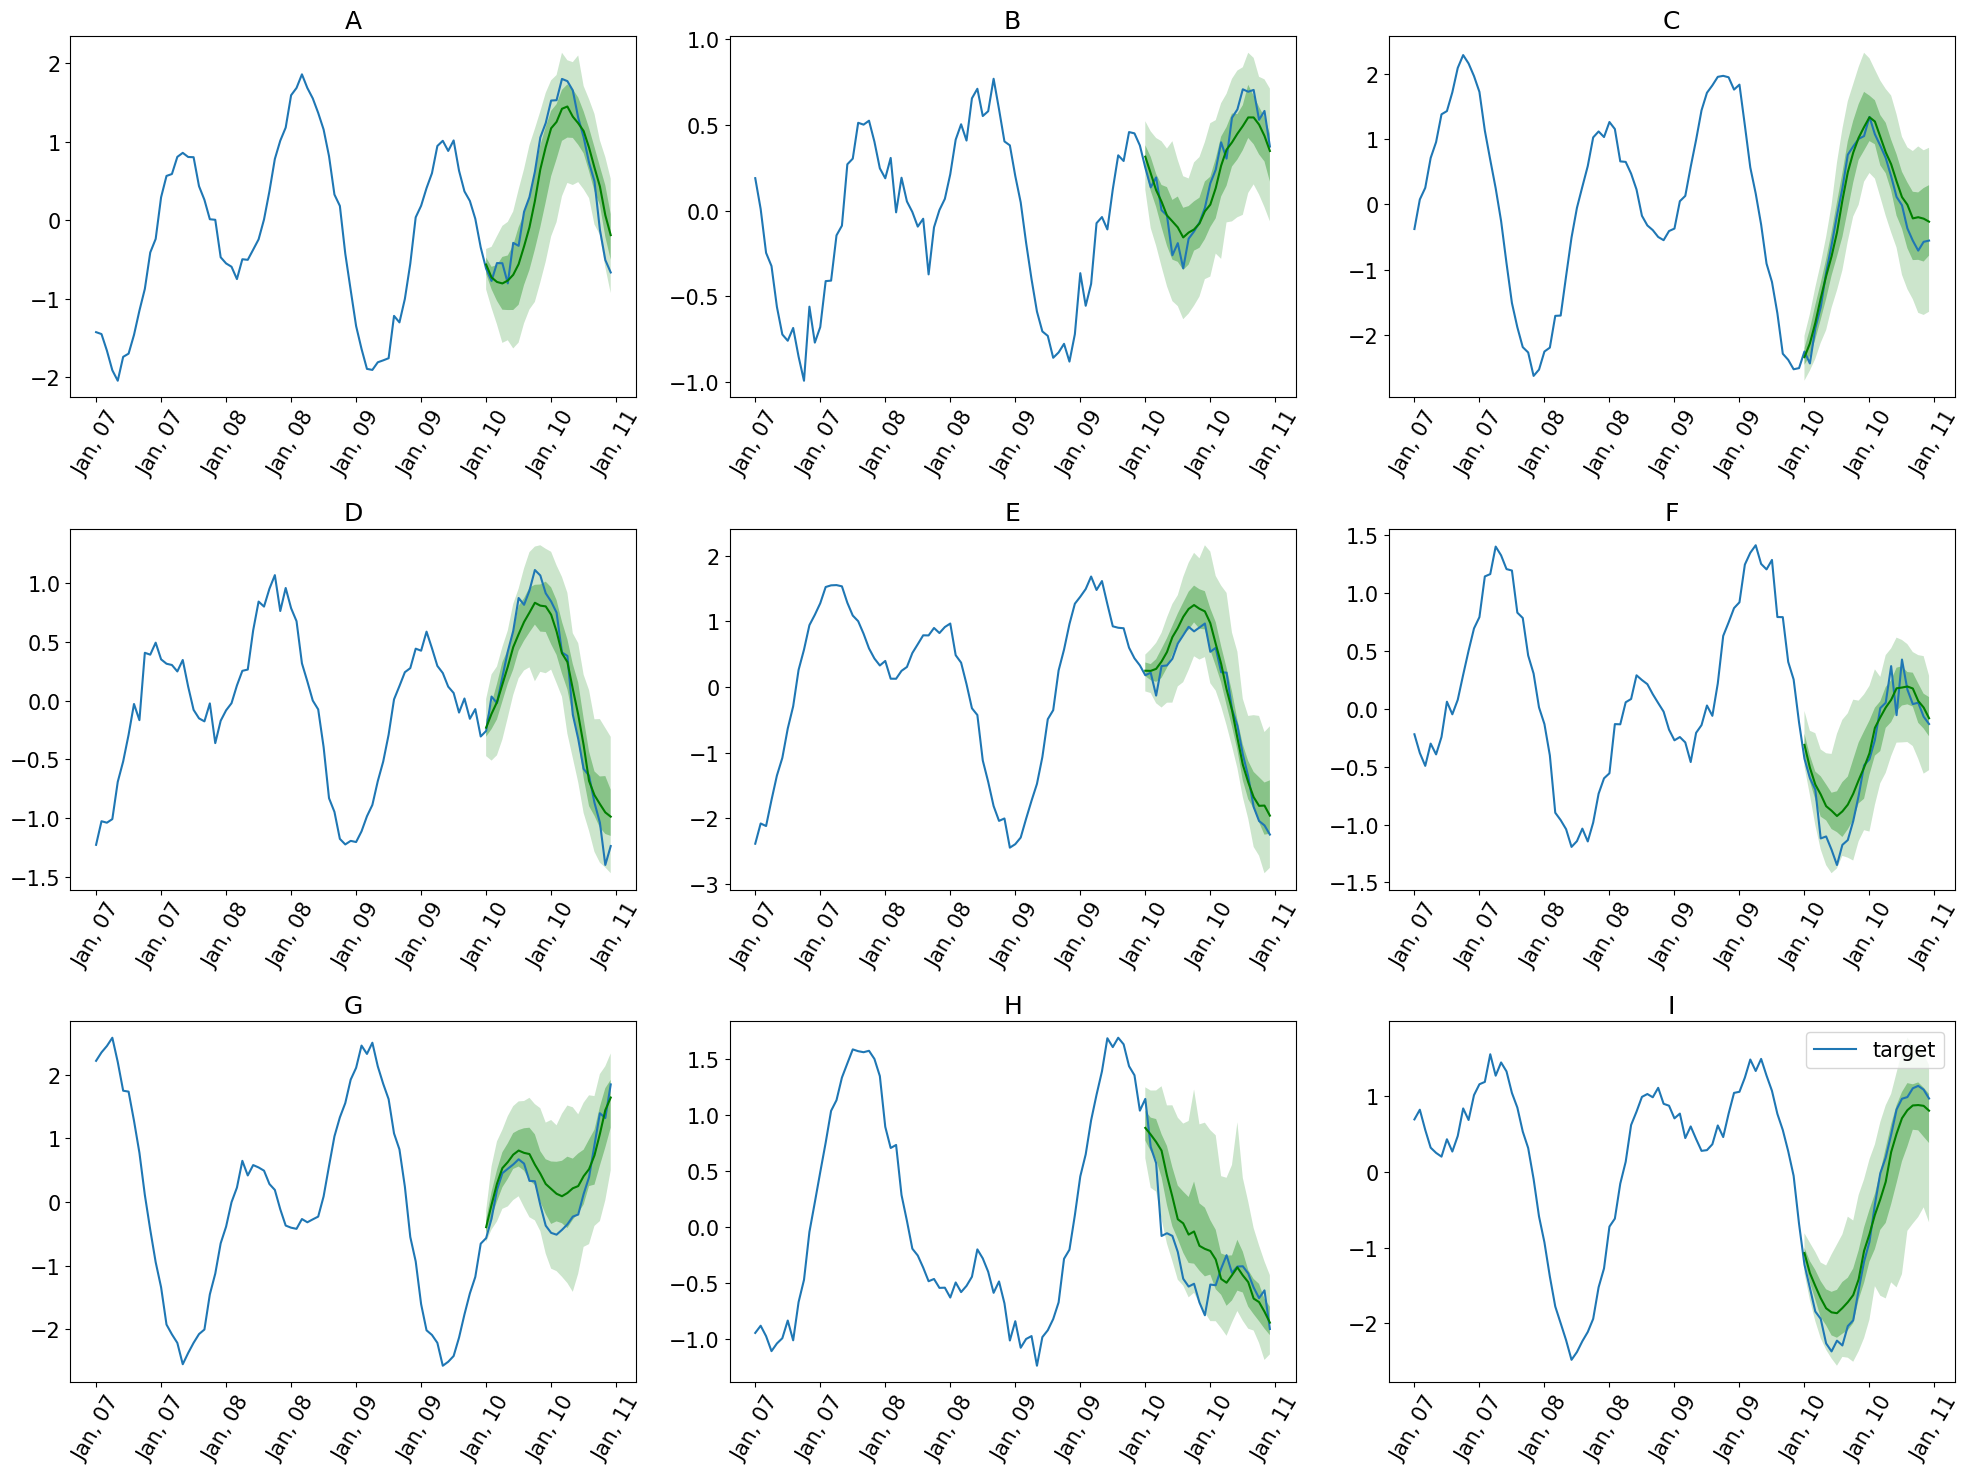

In [19]:
plt.figure(figsize=(20, 15))
date_formater = mdates.DateFormatter('%b, %d')
plt.rcParams.update({'font.size': 15})

# Iterate through the first 9 series, and plot the predicted samples
for idx, (forecast, ts) in islice(enumerate(zip(forecasts, tss)), 9):
    ax = plt.subplot(3, 3, idx+1)

    plt.plot(ts[-4 * prediction_length:].to_timestamp(), label="target", )
    forecast.plot( color='g')
    plt.xticks(rotation=60)
    ax.xaxis.set_major_formatter(date_formater)
    ax.set_title(forecast.item_id)

plt.gcf().tight_layout()
plt.legend()
plt.show()

In [20]:
from gluonts.evaluation import Evaluator

evaluator = Evaluator()
agg_metrics, item_metrics = evaluator(iter(tss), iter(forecasts), num_series=len(backtest_dataset))

print(agg_metrics)

Running evaluation: 100%|██████████| 10/10 [00:00<00:00, 180.56it/s]


{'MSE': 0.08072951088349024, 'abs_error': 50.94084548950195, 'abs_target_sum': 167.5468020439148, 'abs_target_mean': 0.6981116751829782, 'seasonal_error': 1.2065524339675904, 'MASE': 0.18441043538195218, 'MAPE': 1.6115081429481506, 'sMAPE': 0.5838340004285177, 'MSIS': 1.5654354253201945, 'QuantileLoss[0.1]': 24.30825615748763, 'Coverage[0.1]': 0.05, 'QuantileLoss[0.2]': 34.628123523294924, 'Coverage[0.2]': 0.15416666666666667, 'QuantileLoss[0.3]': 41.91300931423902, 'Coverage[0.3]': 0.325, 'QuantileLoss[0.4]': 47.38750849217176, 'Coverage[0.4]': 0.4708333333333332, 'QuantileLoss[0.5]': 50.94084510020912, 'Coverage[0.5]': 0.6083333333333334, 'QuantileLoss[0.6]': 50.08340922147036, 'Coverage[0.6]': 0.7125, 'QuantileLoss[0.7]': 46.23357027173043, 'Coverage[0.7]': 0.8333333333333334, 'QuantileLoss[0.8]': 40.35551400184631, 'Coverage[0.8]': 0.9416666666666668, 'QuantileLoss[0.9]': 29.009321266412726, 'Coverage[0.9]': 0.9958333333333333, 'RMSE': 0.28412939109407576, 'NRMSE': 0.40699704817227

In [21]:
from gluonts.model.seasonal_naive import SeasonalNaivePredictor
# Naive2Predictor simply repeats the last value for the prediction length
freq = '1H'  
baseline_predictor = SeasonalNaivePredictor(prediction_length=prediction_length, freq=freq)
# Generate forecasts using the baseline model
baseline_forecasts = baseline_predictor.predict(backtest_dataset)
forecast_it, ts_it = make_evaluation_predictions(backtest_dataset, baseline_predictor, num_samples)
forecasts = list(forecast_it)
tss = list(ts_it)

from gluonts.evaluation import Evaluator
evaluator = Evaluator()
agg_metrics_seasonal, item_metrics_seasonal = evaluator(iter(tss), iter(forecasts), num_series=len(backtest_dataset))
print(agg_metrics_seasonal)

Running evaluation: 100%|██████████| 10/10 [00:00<00:00, 220.33it/s]


{'MSE': 2.019259027640025, 'abs_error': 289.8011074066162, 'abs_target_sum': 167.5468020439148, 'abs_target_mean': 0.6981116751829782, 'seasonal_error': 1.2065524339675904, 'MASE': 1.0030479626737727, 'MAPE': 8.477708133061727, 'sMAPE': 1.4704060792922973, 'MSIS': 40.121917641308286, 'QuantileLoss[0.1]': 295.70789992362256, 'Coverage[0.1]': 0.4625, 'QuantileLoss[0.2]': 294.2312000602484, 'Coverage[0.2]': 0.4625, 'QuantileLoss[0.3]': 292.7545001968741, 'Coverage[0.3]': 0.4625, 'QuantileLoss[0.4]': 291.27780033349995, 'Coverage[0.4]': 0.4625, 'QuantileLoss[0.5]': 289.8011004701257, 'Coverage[0.5]': 0.4625, 'QuantileLoss[0.6]': 288.32440060675145, 'Coverage[0.6]': 0.4625, 'QuantileLoss[0.7]': 286.84770074337723, 'Coverage[0.7]': 0.4625, 'QuantileLoss[0.8]': 285.37100088000295, 'Coverage[0.8]': 0.4625, 'QuantileLoss[0.9]': 283.89430101662873, 'Coverage[0.9]': 0.4625, 'RMSE': 1.421006343279306, 'NRMSE': 2.0355000407447044, 'ND': 1.729672568329045, 'wQuantileLoss[0.1]': 1.764927150600679, 'w